With GridMethod.jl we can solve real polynomial systems....


In [1]:
import Pkg
Pkg.add("HomotopyContinuation")
Pkg.add("Plots")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Dropbox/GitHubGalois/GridMethod.jl/Project.toml`
  No Changes to `~/Dropbox/GitHubGalois/GridMethod.jl/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Dropbox/GitHubGalois/GridMethod.jl/Project.toml`
  No Changes to `~/Dropbox/GitHubGalois/GridMethod.jl/Manifest.toml`


In [2]:
using .Iterators
using Test
using LinearAlgebra
using GridMethod.Polynomial
using GridMethod.Norms
using GridMethod.ConditionNumbers
const CN = ConditionNumbers
using GridMethod.GridModule
using GridMethod.Han
using GridMethod.Coordinates
using GridMethod
using HomotopyContinuation
using Plots

In [3]:
import HomotopyContinuation.ModelKit
const HCMK = ModelKit

HomotopyContinuation.ModelKit

In [4]:
using Plots

function gridGroupByDepth(G::Grid{T, dim}) where {T, dim}
    I = unique(sort(depth.(G)))
    out = Dict(I .=> [empty(G) for _ in I ])
    for g in G
        d = depth(g)
        push!(out[d], g)
    end
    return out
end

xyAxes(G) = eachrow(reduce(hcat, map(coordinates, gridnodes(G))))

@recipe function f(G::Grid{Float64,2};
                   r = 2,
                   R = 20,
                   f_ms = i -> r + R*(.5)^i, # Marker size
                   f_ma = (d, dmin, dmax) -> (d - dmin + 1)/(dmax - dmin + 1), # Mark alpha/opacity
                   f_msw = (d, dmin, dmax) -> r/10 + (1 - f_ma(d, dmin, dmax))/r, # Border width (0 = No border)
                   color = "rgb(238,37,35)"
                   )
    Dict_depth = gridGroupByDepth(G)
    I = sort!(collect(keys(Dict_depth))) # Sort it for the legend
    dmin = first(I)
    dmax = last(I)
    # Set default values
    axis --> ([-1.1,1.1],)
    # xaxis --> ("x",)
    # yaxis --> ("y",)
    legend --> :outerright
    legendfontsize --> 10
    thickness_scaling --> 1
    shift = dmin -1
    # Plot each depth group
    for d in I
        x, y = xyAxes(Dict_depth[d])
        @series begin
            seriestype := :scatter
            label := "Depth $d"
            # markershape := :circle
            ms := f_ms(d - shift) # Mark size
            mc := color # Mark color
            ma := f_ma(d, dmin, dmax) # Mark alpha/opacity
            msw := f_msw(d, dmin, dmax) # Border/stroke width
            # msw := 0 # No border/stroke
            msc := color # Border color
            msa := f_ma(d, dmin, dmax)/r # Border alpha
            x, y
        end
    end
end

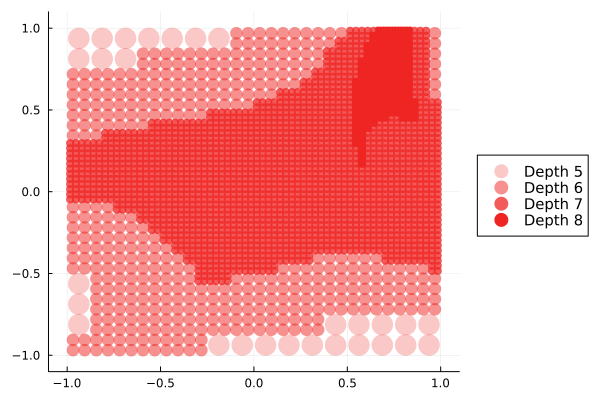

In [14]:
HCMK.@var x,y

polysys = HCMK.System(
    [
        randn()+randn()*x+randn()*y+randn()*x^2+randn()*x*y+randn()*y^2+randn()*x^3+randn()*x^2*y+randn()*x*y^2+randn()*y^3+randn()*x^4+randn()*x^3*y+randn()*x^2*y^2+randn()*x*y^3+randn()*y^4,
        randn()+randn()*x+randn()*y+randn()*x^2+randn()*x*y+randn()*y^2+randn()*x^3+randn()*x^2*y+randn()*x*y^2+randn()*y^3+randn()*x^4+randn()*x^3*y+randn()*x^2*y^2+randn()*x*y^3+randn()*y^4,
    ];
    variables=[x,y]
    )
jacobian = v -> HCMK.jacobian(polysys, v)

gridPolySys::PolynomialSystem{Float64} =
    PolynomialSystem{Float64}(
        v -> polysys(v),
        jacobian,
        HCMK.degrees(polysys),
        HCMK.support_coefficients(polysys)[2]
    )
grid = Grid{Float64, 2}(gridPolySys, [], nothing)
gridHan!(grid,UInt(1);maxDepth=UInt(15))
plot(grid)

In [15]:
grid.est_condition

108.14391132532971

In [16]:
log(grid.est_condition)

4.683462852389192